In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl 
import os

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import r2_score
from scipy import stats
import csv
import statsmodels.api as sm

In [4]:
from load_data import load_processed_general_data
from load_data import load_processed_society_data
from load_data import load_processed_quality_of_life_data

In [5]:
def MinMaxNormal(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [6]:
def denormal(normalized_df,original_df):
    df = (normalized_df*(original_df.max()-original_df.min()))
    df+=original_df.min()
    return df

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    MSPE = mean_squared_error(y_true,y_pred,squared = True)/np.mean(y_true) * 100
    return np.abs(MSPE)

In [8]:
def R2test(test_set,value_set):
    results = []
    for i in  range(len(value_set[0,:])):
        R2 = r2_score(test_set,value_set[:,i])
        results.append(R2)
    return results

In [9]:
def produce_predictions_linear_regression(train_X, test_X, train_y, test_y):
    # data fitting
    model = LinearRegression().fit(train_X, train_y)
    # make predictions
    predictions = model.predict(test_X)
    return predictions,model

In [10]:
median_houses_2020,lower_quatile_houses_2020,A_B_property_counts,C_D_property_counts,E_F_property_counts,G_H_property_counts,local_authority_names = load_processed_general_data()
lower_quatile_earning_2020,ratio_by_lower_quatile_2020,median_earning_2020,median_earning_2020,ratio_by_medians_2020 = load_processed_society_data()
taxi_only_licensed_drivers,total_drivers,education_sector_size,health_sector_size,art_and_entertainment_sector_size = load_processed_quality_of_life_data()

In [11]:
quality_of_life_dataframe = pd.DataFrame([A_B_property_counts,C_D_property_counts,E_F_property_counts,G_H_property_counts,ratio_by_lower_quatile_2020,ratio_by_medians_2020,taxi_only_licensed_drivers,total_drivers,education_sector_size,health_sector_size,art_and_entertainment_sector_size])

In [12]:
quality_of_life_dataframe = quality_of_life_dataframe.transpose()

In [13]:
train_X, test_X, train_y, test_y = train_test_split(quality_of_life_dataframe, median_houses_2020, test_size=0.2, random_state=0,)

In [14]:
# normalization
train_X_norm = MinMaxNormal(train_X)
test_X_norm = MinMaxNormal(test_X)
train_y_norm = MinMaxNormal(train_y)
test_y_norm = MinMaxNormal(test_y)

In [15]:
# with statsmodels
XX = sm.add_constant(train_X_norm) # adding a constant
test_stats_model_overall = sm.add_constant(test_X_norm) # adding a constant
statsmodel_model = sm.OLS(train_y_norm, XX).fit()
statsmodel_predictions = statsmodel_model.predict(test_stats_model_overall) 
print_model = statsmodel_model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     median_houses_2020   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     325.2
Date:                Mon, 21 Mar 2022   Prob (F-statistic):          8.73e-136
Time:                        20:14:19   Log-Likelihood:                 525.79
No. Observations:                 248   AIC:                            -1028.
Df Residuals:                     236   BIC:                            -985.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [16]:
# De-Normalized Predicted Data 
predicted_house_price_denorm = denormal(statsmodel_predictions,test_y)

In [17]:
# predictions and model
f_predictions,example_model = produce_predictions_linear_regression(train_X_norm, test_X_norm, train_y_norm, test_y_norm)

In [18]:
# Return the normalized values to real values
f_predictions = denormal(f_predictions,test_y)

In [21]:
example_mlr_scores = pd.DataFrame(example_model.coef_)

In [22]:
example_mlr_scores.columns = ['Scores']
example_mlr_scores.index = ['A_B_property_counts','C_D_property_counts','E_F_property_counts','G_H_property_counts',
                           'ratio_by_lower_quatile','ratio_by_medians','Taxi_only_licensed_drivers','total_drivers','Education',
                           'Health','Arts, entertainment, recreation & other services']

In [23]:
cwd = os.getcwd()
example_mlr_scores.to_csv(os.path.join(cwd, "example_mlr_model_scores.csv"))  

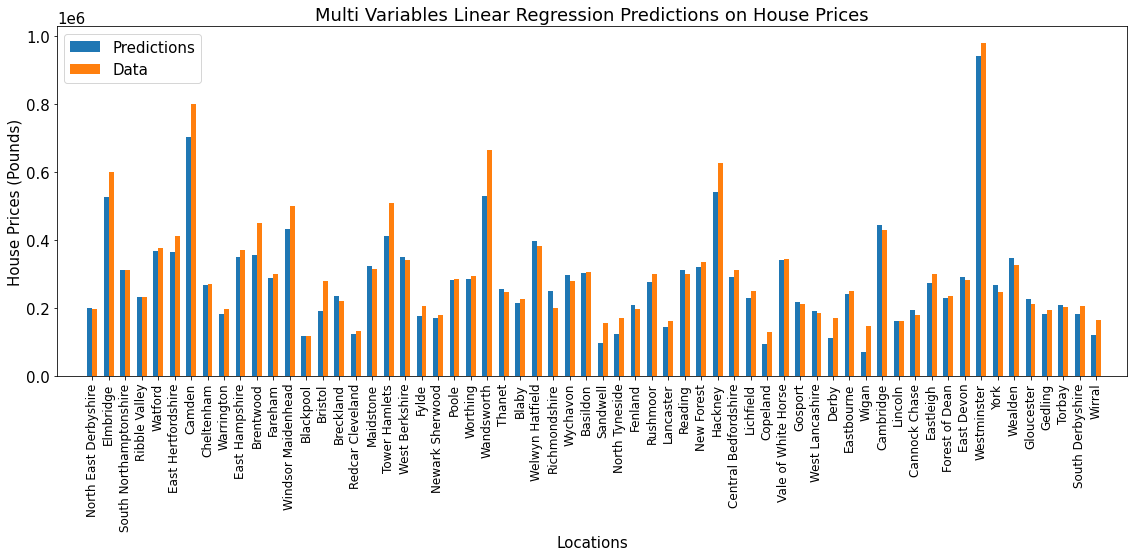

In [33]:
N =len(f_predictions)
locations = range(1,N+1)

# Position of bars on x-axis
y_pos = np.arange(N)

# Width of a bar 
width = 0.3
# Plotting
plt.rcParams.update({'font.size': 15})
fig_r2, ax = plt.subplots(figsize=(16,8))
plt.bar(y_pos, f_predictions , width, label='Predictions')
plt.bar(y_pos + width, test_y, width, label='Data')
plt.xlabel('Locations')
plt.ylabel('House Prices (Pounds)')
plt.title('Multi Variables Linear Regression Predictions on House Prices')

# xticks()
plt.xticks(y_pos + width / 2, list(local_authority_names[test_y.index]))
plt.setp(ax.get_xticklabels(), fontsize=12, rotation='vertical')
# Size of the Plot
plt.xlim([-2,max(y_pos)+2])
# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('full_prediction_plots.png')
plt.show()